# HSCT survival: Scikit-learn gradient boosting model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from lifelines.utils import concordance_index

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-multicollinear_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/05.1-hyperparameter_tuning_results.csv'

# Model files
naive_model_file=f'{config.MODELS_PATH}/05.1-sklearn_gradient_boosting_naive.pkl'
tuned_model_file=f'{config.MODELS_PATH}/05.1-sklearn_gradient_boosting_tuned.pkl'

# Scoring results
training_scores_file=f'{config.DATA_PATH}/results/data/05.1-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/05.1-testing_scores.csv'


retune_model=True

## 1. Load data

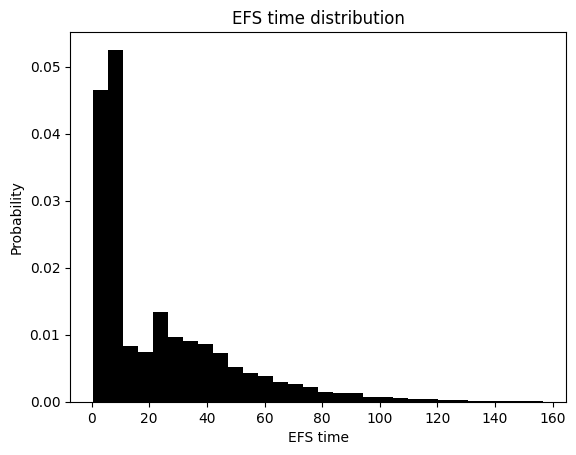

Training features: (28800, 149)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

# Clean up column names
data_df.columns=data_df.columns.str.replace('[\\[\\]<]', '', regex=True)

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28800 entries, 0 to 28799
Columns: 149 entries, hla_match_c_high to race_group
dtypes: float64(27), int32(121), object(1)
memory usage: 19.7+ MB


## 2. Data preparation

### 2.1. Train-test split

In [4]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

### 2.2. Save and remove training & testing race group

In [5]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Make features and labels

In [6]:
training_labels_df=training_df[['efs', 'efs_time']].copy()
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
training_labels_df['sqrt_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/training_labels_df['efs_time']

testing_labels_df=testing_df[['efs', 'efs_time']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels_df['sqrt_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/testing_labels_df['efs_time']

## 3. Label transformation testing

Label type: efs_time


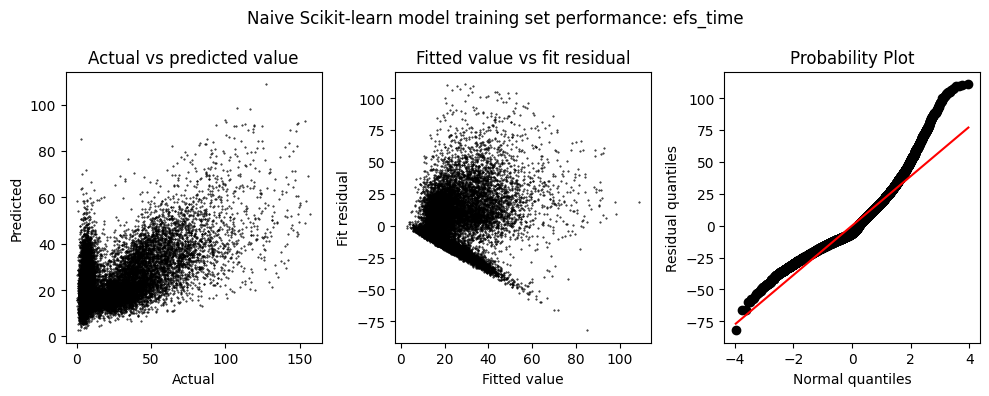

Label type: log_efs_time


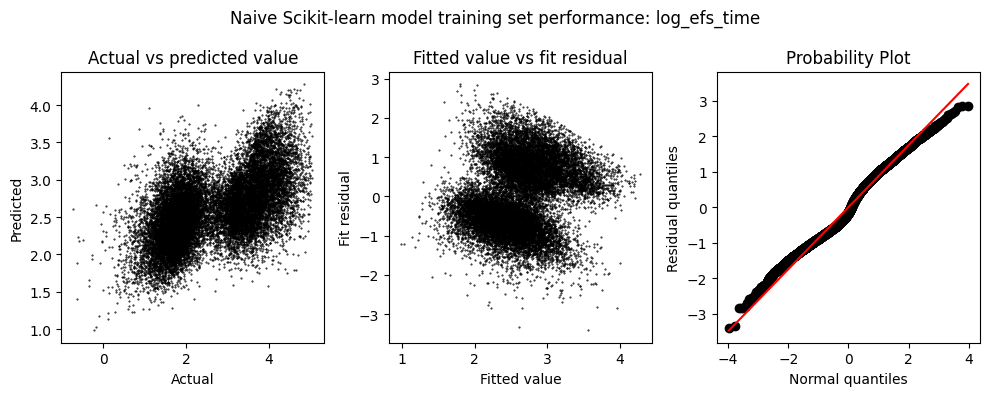

Label type: sqrt_efs_time


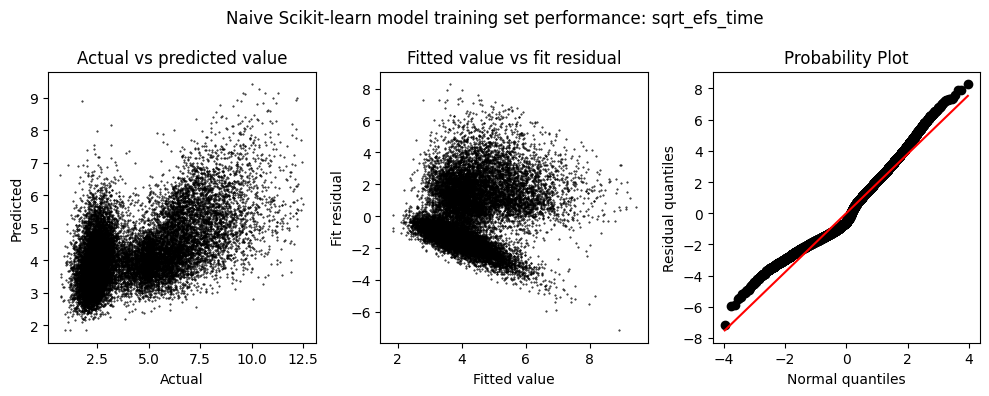

Label type: reciprocal_efs_time


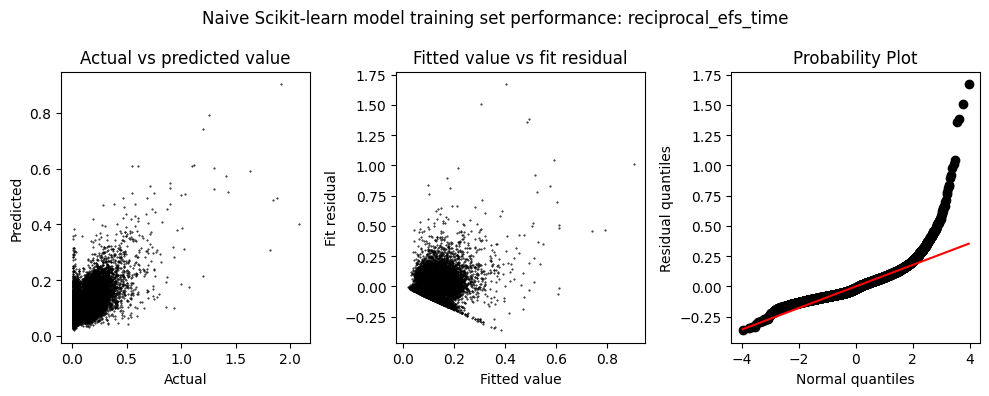

In [7]:
label_types=['efs_time', 'log_efs_time', 'sqrt_efs_time', 'reciprocal_efs_time']

training_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

testing_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for label_type in label_types:

    print(f'Label type: {label_type}')

    # SKlearn gradient boosting model
    naive_model=HistGradientBoostingRegressor(random_state=315)

    # Fit the model
    naive_model.fit(
        training_features_df,
        training_labels_df[label_type]
    )

    # Make predictions for the training set
    training_predictions=naive_model.predict(training_features_df)

    # Make fit diagnostic plots
    plot=plot_funcs.prediction_eval_plot(
        f'Naive Scikit-learn model training set performance: {label_type}',
        training_predictions,
        training_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(f'{config.DATA_PATH}/results/plots/05.1-fit_diagnostics_naive_sklearn_model_{label_type}.jpg', dpi=300)
    plot.show()

    # Score the training set predictions for RMSE, C-index and stratified C-index
    training_score_results=helper_funcs.score_predictions(
        model_description=f'Naive: {label_type}',
        predictions=training_predictions,
        labels_df=training_labels_df,
        race_group=training_race_group,
        results=training_score_results,
        label_type=label_type
    )

## 4. Hyperparameter tuning

In [8]:
# Manually choose best label transformation based on above plots
label_type='sqrt_efs_time'

# Train or load model as desired
if retune_model == True:
    
    # Instantiate the model
    model=HistGradientBoostingRegressor(random_state=315)

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Define the hyperparameter search space
    distributions={
        'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
        #'n_estimators': list(range(5, 100)), only valid for GBC, not HGBC
        'max_depth': list(range(5, 50)),
        #'min_samples_split': list(range(2, 50)),
        'min_samples_leaf': list(range(1, 50)),
        #'subsample': stats.uniform(loc=0.5, scale=0.4)
    }

    # Set-up the search
    search=RandomizedSearchCV(
        model,
        distributions,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cross_validation,
        n_iter=500,
        random_state=315,
        return_train_score=True
    )

    results=search.fit(
        training_features_df,
        training_labels_df['efs_time']
    )

    results_df=pd.DataFrame.from_dict(results.cv_results_).sort_values('mean_test_score', ascending=True)
    results_df.reset_index(inplace=True, drop=False)
    
    print(f'Best hyperparameters: {results.best_params_}')

    # Instantiate the model with the tuned hyperparameters
    tuned_model=HistGradientBoostingRegressor(**results.best_params_, random_state=315)

    tuned_model.fit(
        training_features_df,
        training_labels_df['efs_time']
    )

    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)
    
elif retune_model == False:
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

Best hyperparameters: {'learning_rate': np.float64(0.0755063323411851), 'max_depth': 6, 'min_samples_leaf': 46}


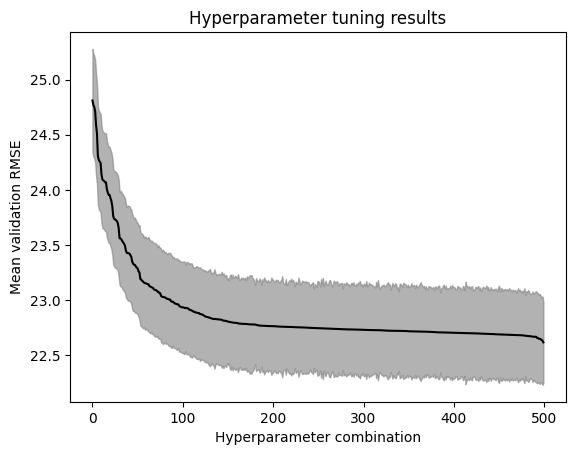

In [9]:
plt.title('Hyperparameter tuning results')
plt.plot(results_df.index, abs(results_df['mean_test_score']), color='black')

plt.fill_between(
    results_df.index,
    abs(results_df['mean_test_score']) - results_df['std_test_score'],
    abs(results_df['mean_test_score']) + results_df['std_test_score'],
    color='gray',
    alpha=0.6
)

plt.xlabel('Hyperparameter combination')
plt.ylabel('Mean validation RMSE')
plt.show()

## 8. Evaluate the tuned model

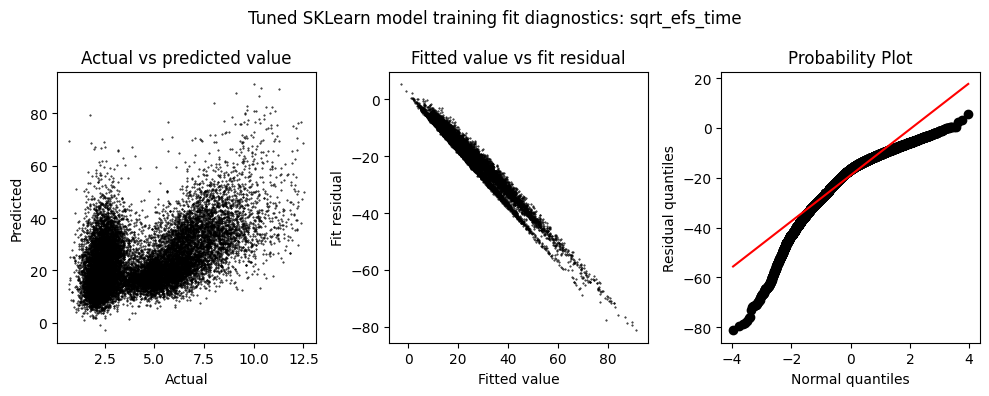

In [10]:
# Make predictions on the training and testing sets
training_predictions=tuned_model.predict(training_features_df)
testing_predictions=tuned_model.predict(testing_features_df)

# Make diagnostic plots for the training set
plot=plot_funcs.prediction_eval_plot(
    f'Tuned SKLearn model training fit diagnostics: {label_type}',
    training_predictions,
    training_labels_df[label_type]
)

# Score the training set predictions for RMSE, C-index and stratified C-index
training_score_results=helper_funcs.score_predictions(
    model_description=f'Tuned: {label_type}',
    predictions=training_predictions,
    labels_df=training_labels_df,
    race_group=training_race_group,
    results=training_score_results,
    label_type=label_type
)

# Score the test set predictions for RMSE, C-index and stratified C-index
testing_score_results=helper_funcs.score_predictions(
    model_description=f'Tuned: {label_type}',
    predictions=testing_predictions,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=testing_score_results,
    label_type=label_type
)

## 9. Model comparison

### 6.1. Training set performance

In [11]:
training_score_results_df=pd.DataFrame.from_dict(training_score_results)
training_score_results_df.to_csv(training_scores_file, index=False)
training_score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,20.056605,0.361252,0.494912
1,Naive: log_efs_time,0.884704,0.286461,0.495550
2,Naive: sqrt_efs_time,1.931617,0.325362,0.493861
3,Naive: reciprocal_efs_time,0.094759,0.336644,0.491169
4,Tuned: sqrt_efs_time,21.281100,0.369933,0.493440


### 6.2. Testing set performance

In [12]:
testing_score_results_df=pd.DataFrame.from_dict(testing_score_results)
testing_score_results_df.to_csv(testing_scores_file, index=False)
testing_score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Tuned: sqrt_efs_time,21.43924,0.405897,0.482797
